In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from random import gauss
from random import seed

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Questions:  

* What's the relation between seasonality and lag correlation (autocorrelation)? Does it make sense to use autocorrelation to assess seasonality when we have a trend?
* 

# BLU04 - Pandas for Timeseries

In [2]:
data = pd.read_csv('BLU04 - Time Series Concepts/data/bitcoin.csv')

In [3]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2017-01-01 00:00:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
1,2017-01-01 00:01:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
2,2017-01-01 00:02:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
3,2017-01-01 00:03:00,973.36,973.36,973.36,973.36,0.040000,38.934400,973.360000
4,2017-01-01 00:04:00,973.36,973.40,973.36,973.39,5.458800,5313.529708,973.387871


**Series `Timestamp` is type object!**

In [4]:
print(data.Timestamp.dtype)

object


In [5]:
data.Timestamp.head()

0    2017-01-01 00:00:00
1    2017-01-01 00:01:00
2    2017-01-01 00:02:00
3    2017-01-01 00:03:00
4    2017-01-01 00:04:00
Name: Timestamp, dtype: object

### Convert to `datetime`

In [6]:
data.Timestamp = pd.to_datetime(data.Timestamp, infer_datetime_format=True)

In [7]:
data.Timestamp.head()

0   2017-01-01 00:00:00
1   2017-01-01 00:01:00
2   2017-01-01 00:02:00
3   2017-01-01 00:03:00
4   2017-01-01 00:04:00
Name: Timestamp, dtype: datetime64[ns]

### Computations on `datetime`

**Now we can use `pandas.Series` methods and `.dt` accessor. For example...**

[Pandas Time series](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)  
[Pandas .dt accessor](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#dt-accessor)

- `.max()`
- `.cumsum()`
- `.cummax()`
- `.rolling()`
- `.diff()`
- `.pct_change()`

In [8]:
data.Timestamp.max()

Timestamp('2018-03-27 00:00:00')

In [9]:
data.Timestamp.dt.minute.head()

0    0
1    1
2    2
3    3
4    4
Name: Timestamp, dtype: int64

Converting to **time since epoch** (number of seconds that have elapsed since 00:00:00, 1 January 1970 UTC) and back.

In [10]:
tse_time = data.Timestamp.astype('int64')
tse_time.head()

0    1483228800000000000
1    1483228860000000000
2    1483228920000000000
3    1483228980000000000
4    1483229040000000000
Name: Timestamp, dtype: int64

In [11]:
pd.to_datetime(tse_time).head()

0   2017-01-01 00:00:00
1   2017-01-01 00:01:00
2   2017-01-01 00:02:00
3   2017-01-01 00:03:00
4   2017-01-01 00:04:00
Name: Timestamp, dtype: datetime64[ns]

### Selecting  

Timestamp is the pandas equivalent of python’s Datetime and is used for the entries that make up a DatetimeIndex.  
See pandas [timestamp documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)

Set Timestamp as the index.

In [12]:
data = data.set_index('Timestamp',drop=True)
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2017-01-01 00:00:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
2017-01-01 00:01:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
2017-01-01 00:02:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
2017-01-01 00:03:00,973.36,973.36,973.36,973.36,0.040000,38.934400,973.360000
2017-01-01 00:04:00,973.36,973.40,973.36,973.39,5.458800,5313.529708,973.387871


**When the index is datetime, it should always be sorted!**

In [13]:
data = data.sort_index()

In [14]:
data[data.index.month == 6].head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2017-06-01 00:00:00,2303.61,2304.15,2303.12,2304.02,3.666929,8448.703295,2304.026682
2017-06-01 00:01:00,2303.88,2304.15,2302.00,2302.00,4.872337,11223.396828,2303.493691
2017-06-01 00:02:00,2303.73,2304.06,2302.05,2303.32,6.266425,14436.511779,2303.787616
2017-06-01 00:03:00,2303.31,2303.31,2302.08,2303.09,2.058130,4740.119791,2303.119788
2017-06-01 00:04:00,2303.09,2307.60,2303.09,2307.60,39.879237,91955.757727,2305.855474


In [15]:
data['01/17/2018'].head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2018-01-17 00:00:00,11570.01,11570.01,11570.00,11570.00,37.374867,4.324275e+05,11570.006518
2018-01-17 00:01:00,11570.01,11699.00,11550.00,11627.09,82.549136,9.575156e+05,11599.340993
2018-01-17 00:02:00,11605.00,11700.22,11550.00,11624.00,78.062113,9.092036e+05,11647.181988
2018-01-17 00:03:00,11624.00,11790.00,11603.14,11725.38,92.075967,1.081329e+06,11743.878594
2018-01-17 00:04:00,11725.52,11800.00,11725.51,11799.99,97.790853,1.153220e+06,11792.718569


In [16]:
data['01/17/2018 1:30PM':'01/17/2018 1:40PM']

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2018-01-17 13:30:00,10320.37,10392.96,10320.36,10389.76,18.829533,194664.293210,10338.243544
2018-01-17 13:31:00,10389.76,10389.76,10310.00,10310.01,13.012326,134782.335550,10358.050813
2018-01-17 13:32:00,10310.00,10347.19,10310.00,10331.86,6.500988,67075.196183,10317.693217
2018-01-17 13:33:00,10331.87,10347.17,10331.87,10339.15,8.774058,90744.731937,10342.389840
2018-01-17 13:34:00,10339.14,10350.01,10330.00,10330.00,17.040271,176266.835200,10344.133215
2018-01-17 13:35:00,10330.00,10330.01,10300.00,10309.24,24.539315,253384.119570,10325.639333
2018-01-17 13:36:00,10309.24,10331.00,10280.00,10327.65,9.886690,101939.982550,10310.830554
2018-01-17 13:37:00,10327.64,10343.14,10327.64,10343.14,3.986264,41195.916036,10334.468167
2018-01-17 13:38:00,10343.13,10343.13,10281.01,10290.50,9.228567,95307.671569,10327.461751


### Resampling  

[pandas resampling](https://pandas.pydata.org/pandas-docs/stable/reference/resampling.html)  
[DataFrame.resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html#pandas.DataFrame.resample)

**1. Resample to get a resampler object**

In [17]:
data.Open.resample('M')

DatetimeIndexResampler [freq=<MonthEnd>, axis=0, closed=right, label=right, convention=start, base=0]

**2. To the resampler object we apply whatever computation is needed:**
- `.count()`
- `.first()`
- `.nunique()`
- `.max()`
- `.mean()`
- `.sum()`
- `.std()`
- `.median()`
- `quantile.()`
- ...


In [18]:
data.Open.resample('M').mean()

Timestamp
2017-01-31      913.900487
2017-02-28     1063.098797
2017-03-31     1136.307935
2017-04-30     1215.875404
2017-05-31     1904.348628
2017-06-30     2618.208685
2017-07-31     2496.632774
2017-08-31     3836.768040
2017-09-30     4110.907916
2017-10-31     5292.596445
2017-11-30     7786.211433
2017-12-31    15106.235051
2018-01-31    12876.412886
2018-02-28     9384.386674
2018-03-31     9322.472714
Freq: M, Name: Open, dtype: float64

### Multi-index  

MultiIndex / advanced indexing [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html).

In [19]:
food = pd.read_csv('BLU04 - Time Series Concepts/data/food.csv')
food.head()

,Store,Product,Price,Quality
0,Incontinente,Apples,3.0,2.0
1,Incontinente,Bananas,2.0,4.0
2,Incontinente,Rice,1.0,3.0
3,Incontinente,Olives,4.0,2.0
4,Dingo Poce,Apples,2.0,2.0


In [20]:
food = food.set_index(['Store', 'Product'])
food.head()

Price  Quality
Store        Product                
Incontinente Apples     3.0      2.0
             Bananas    2.0      4.0
             Rice       1.0      3.0
             Olives     4.0      2.0
Dingo Poce   Apples     2.0      2.0

**Always, always, sort the indexes in a multi-index Dataframe.**

In [21]:
food = food.sort_index()
food

Price  Quality
Store        Product                 
Dingo Poce   Apples      2.0      2.0
             Bananas     3.0      3.0
             Dog food    7.0      1.0
             Rice        1.0      4.0
Dumbo        Apples      2.0      3.0
             Dog food    1.0      2.0
             Rice        5.0      4.0
Incontinente Apples      3.0      2.0
             Bananas     2.0      4.0
             Olives      4.0      2.0
             Rice        1.0      3.0

### Selecting in multi-index  

In [22]:
food.loc[(slice(None), slice('Apples', 'Apples')), 'Price']

Store         Product
Dingo Poce    Apples     2.0
Dumbo         Apples     2.0
Incontinente  Apples     3.0
Name: Price, dtype: float64

In [23]:
idx = pd.IndexSlice
food.loc[idx[: , 'Apples'], 'Price']

Store         Product
Dingo Poce    Apples     2.0
Dumbo         Apples     2.0
Incontinente  Apples     3.0
Name: Price, dtype: float64

In [24]:
df = pd.DataFrame({'col1':[1,3,5], 'col2':[2,1,7]})
df

,col1,col2
0,1,2
1,3,1
2,5,7


In [25]:
df[0:1]

,col1,col2
0,1,2


## Seasonal decomposition  

Time series can be thought as a (linear or non-linear) composition of 4 components: **trend**, **cyclical**, **seasonal** and **irregular**

$Y_t = Trend + Seasonal + Cyclical + residual$,  

or

$Y_t = Trend \cdot Seasonal \cdot Cyclical \cdot residual$,  

or yet another non-linear combination of all four. Each one of the previous four components is itself also a time series.  

In order to understand these concepts, let's look at a dataset with [monthly totals of a US airline passangers from 1949 to 1960](https://www.kaggle.com/chirag19/air-passengers)

In [26]:
# Read csv file
airlines = pd.read_csv('BLU05 - Classical Time Series Models/data/international-airline-passengers.csv',
                       header=0,
                       names = ['Month', 'thousands of passengers'])

# drop last line
airlines = airlines.dropna()

# month as index
airlines.Month = pd.to_datetime(airlines.Month)
airlines = airlines.set_index('Month')

#convert to series
airlines = airlines['thousands of passengers']

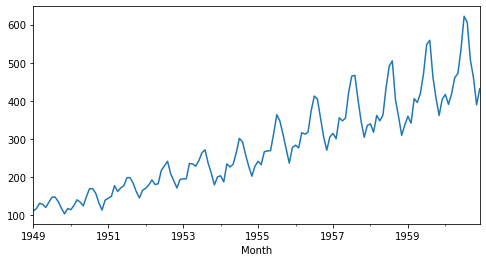

In [64]:
airlines.plot(figsize=(8, 4));

**Trend**

The trend is the component of the time series that allows us to see if, overall, the dependent variable we are observing is increasing or decreasing, without taking into consideration local flutuations.  

The first thing you probably notice in the passengers time series is that, in general, the *passengers are increasing* even though there are anual peaks.  

There are different approaches to visualize the trend, like:
* a simple linear regression;
* the moving average;

In [28]:
lr = LinearRegression()

y = airlines.values.reshape(-1,1)
X = np.array(range(y.shape[0])).reshape(-1,1)
lr.fit(X, y)

linear_trend = pd.Series(lr.predict(X).reshape(-1,), index=airlines.index)

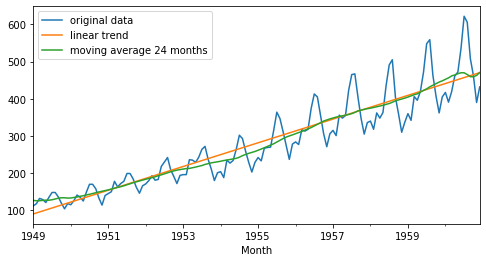

In [63]:
airlines.plot(label="original data", figsize=(8, 4))
linear_trend.plot(label="linear trend")
airlines.rolling(24,  min_periods=12, center=True).mean().plot(label="moving average 24 months")
plt.legend();

**Seasonal**

Unlike the cyclical component, the seasonal component changes at a fixed rate. For example, the bookings in hotels in certain cities have well known maxima (Summer) and minima (Winter).  

In our time series we can see yearly minima and maxima approximately in the same months.

Auto-correlation may help to identify seasonal patterns. For example, if there is a yeraly seasonality then auto-correlation should be higher with $lag = 12$ and lower in between.

In [30]:
corrs = {}

for lag in range(13):
    corrs[lag] = airlines.corr(airlines.shift(lag))

pd.Series(corrs)

0     1.000000
1     0.960195
2     0.895675
3     0.837395
4     0.797735
5     0.785943
6     0.783919
7     0.784592
8     0.792215
9     0.827852
10    0.882713
11    0.949702
12    0.990527
dtype: float64

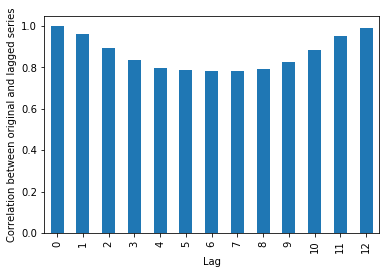

In [55]:
pd.Series(corrs).plot(kind='bar')
plt.xlabel('Lag')
plt.ylabel('Correlation between original and lagged series')
plt.show();

**Cyclical**

The cyclical component is a time series that exhibits a behavior that **repeats in non-regular time intervals**. For example, the performance of the world economy in the 20st century would exhibit a strong cyclical component with non-regular cycles (remember the crisis at the 80's and 2007).

**Residual**

After accounting for all the previous components, the remaining component, called *irregular* or *residual*, won't have any pattern. This part of the time series is considered noise. It is used in several modelling techniques in order to check if a better model can be created.

# BLU05 - Classical Time Series Models  

So far we have learned fundamental concepts to start modelling time series, now we'll finally learn how to actually model them. For that, we're going to dive a bit deeper into their components using a very useful library: _statsmodels_.  

We will use StatsModels extensively. Statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration

(see StatsModels' [documentation](https://www.statsmodels.org/stable/index.html)).

`from statsmodels.tsa.seasonal import seasonal_decompose`

### Trend and seasonal components using [seasonal_decompose()](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html).

First...how do we know if our time series is **additive or multiplicative?** Citing [Hyndman & Athanasopoulos](https://otexts.org/fpp2/components.html)

> _The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series._

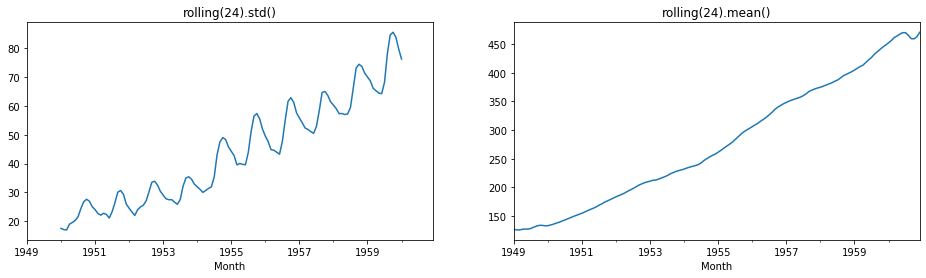

In [81]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
airlines.rolling(24, center=True).std().plot()
plt.title('rolling(24).std()')

plt.subplot(122)
airlines.rolling(24,  min_periods=12, center=True).mean().plot(label="moving average 24 months")
plt.title('rolling(24).mean()')
plt.show()

In our case the standard deviation increases as the trend increases, which means that the time series is multiplicative.  

A commom way to make the time series additive is to apply the log transformation. The trend continues to be increasing but the standard deviation stabilizes around an average value.

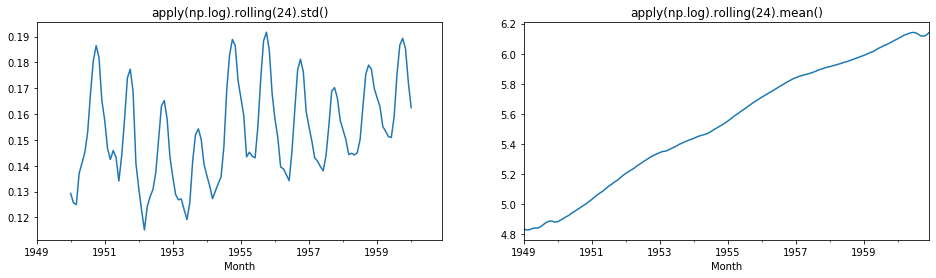

In [83]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
airlines.apply(np.log).rolling(24, center=True).std().plot()
plt.title('apply(np.log).rolling(24).std()')

plt.subplot(122)
airlines.apply(np.log).rolling(24,  min_periods=12, center=True).mean().plot(label="moving average 24 months")
plt.title('apply(np.log).rolling(24).mean()')
plt.show()

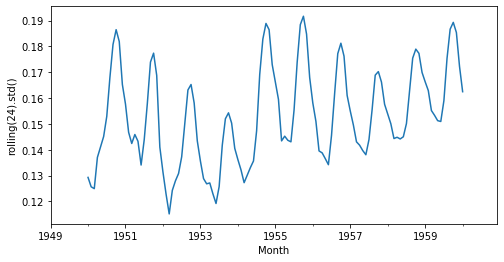

In [67]:
airlines.apply(np.log).rolling(24, center=True).std().plot(figsize=(8, 4))
plt.ylabel('rolling(24).std()')
plt.show()

There are several ways to implement this: using [moving averages](https://otexts.org/fpp2/classical-decomposition.html), [X11](https://otexts.org/fpp2/x11.html), [SEATS](https://otexts.org/fpp2/seats.html) and [STL](https://otexts.org/fpp2/stl.html). In this BLU, we will use the moving averages approach that was implemented in [statsmodel](https://www.statsmodels.org/stable/index.html), a python module with a rich set of plots, models and validation procedures for time series.

In [32]:
np.random.seed(10)

time_idx = pd.date_range(start='01/01/2010', end='01/08/2018')
df = pd.DataFrame(index = time_idx)


df['trend'] = range(df.index.size)
df['seasonal'] = np.cos((df.index.dayofyear/365 -0.5)*2*np.pi)
df['noise'] = np.random.randn(df.index.size)

df['data'] = (0.1/365)*df.trend + 0.3*df.seasonal + 0.3*df.noise
df.data = df.data.rolling(7, min_periods=1).mean()

#data['seasonal'] = np.cos(data.index.dayofyear*2*np.pi/365 - np.pi)


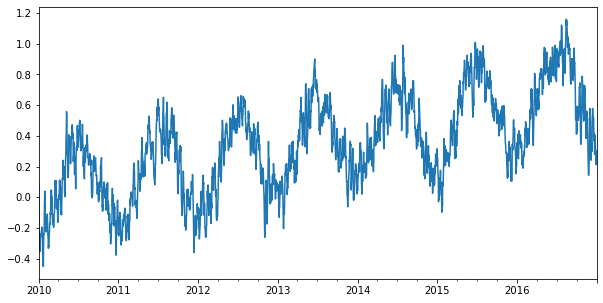

In [33]:
df.data['2010':'2016'].plot(figsize=(10,5))

In [34]:
decomposition = seasonal_decompose(df.data, model='additive')

statsmodel includes a function to plot all 3 components at once

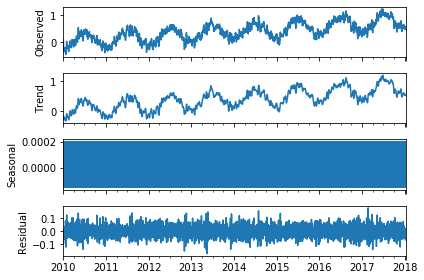

In [35]:
decomposition.plot()
plt.show()

also, we have direct access to all 3 components

In [36]:
df.seasonal.describe()

count    2930.000000
mean       -0.003403
std         0.708411
min        -1.000000
25%        -0.714673
50%        -0.004304
75%         0.708627
max         0.999963
Name: seasonal, dtype: float64

In [37]:
decomposition.trend.head(10)

2010-01-01         NaN
2010-01-02         NaN
2010-01-03         NaN
2010-01-04   -0.169412
2010-01-05   -0.229594
2010-01-06   -0.280842
2010-01-07   -0.286913
2010-01-08   -0.288303
2010-01-09   -0.290296
2010-01-10   -0.286941
Freq: D, Name: data, dtype: float64

**Autocorrelation function**  

Also known as serial correlation, is the correlation of a signal with a delayed copy of itself as a function of delay.

In [38]:
monthly_data = df.data.resample('M').mean()
autocorr = {}

for lag in range(25):
    autocorr[lag] = monthly_data.corr(monthly_data.shift(lag))
    
pd.Series(autocorr).head(13)

0     1.000000
1     0.911741
2     0.746988
3     0.503704
4     0.267229
5     0.095565
6     0.025495
7     0.078366
8     0.251337
9     0.483648
10    0.728398
11    0.898844
12    0.966047
dtype: float64

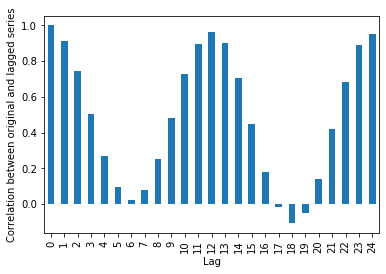

In [39]:
pd.Series(autocorr).plot(kind='bar')
plt.xlabel('Lag')
plt.ylabel('Correlation between original and lagged series')
plt.show();

... using StatsModels, see [acf()](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html?highlight=acf#statsmodels.tsa.stattools.acf) and [plot_acf()](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html?highlight=plot_acf#statsmodels.graphics.tsaplots.plot_acf) documentation.

In [40]:
acf(monthly_data, unbiased=True)

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\envs\BLU05\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([ 1.        ,  0.90131284,  0.73066842,  0.48896134,  0.25822999,
        0.08892836,  0.01926995,  0.06669754,  0.2210986 ,  0.42439754,
        0.64010206,  0.78205061,  0.83015896,  0.75569786,  0.57348716,
        0.34521204,  0.11518121, -0.05767426, -0.14134728, -0.09791354,
        0.05173616,  0.26710174,  0.46092041,  0.60169768,  0.62762558,
        0.55799344,  0.37013926,  0.12600788, -0.10465382, -0.27625391,
       -0.34319977, -0.2853154 , -0.14167619,  0.0626335 ,  0.24239568,
        0.36709938,  0.39163968,  0.30391971,  0.12706063, -0.10381808,
       -0.32522157])

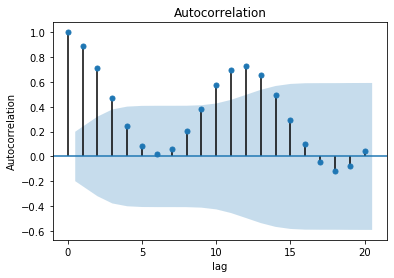

In [41]:
plot_acf(monthly_data, alpha=.05)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

using partial autocorrelation to account for 

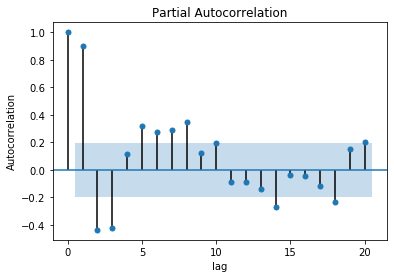

In [42]:
plot_pacf(monthly_data, alpha=.05)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

## ARIMA -  AR (Auto Regressive) I (Integrated) MA (Moving Average)  

ARIMA model class [documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html).  
ARIMA results class [documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMAResults.html#statsmodels.tsa.arima_model.ARIMAResults).

Load data.

In [43]:
# Read csv file
airlines = pd.read_csv('BLU05 - Classical Time Series Models/data/international-airline-passengers.csv',
                       header=0,
                       names = ['Month', 'thousands of passengers'])

# drop last line
airlines = airlines.dropna()

# month as index
airlines.Month = pd.to_datetime(airlines.Month)
airlines = airlines.set_index('Month')

#convert to series
airlines = airlines['thousands of passengers']

First, we should **stabilize the variance** so that it is approximatelly constant over time. The most common way to do that, is to apply the log transform.

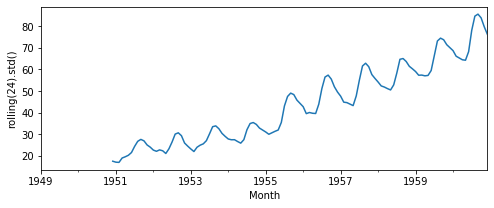

In [44]:
airlines.rolling(24).std().plot(figsize=(8, 3))
plt.ylabel('rolling(24).std()')
plt.show()

In [45]:
airlines_logged = airlines.map(np.log)

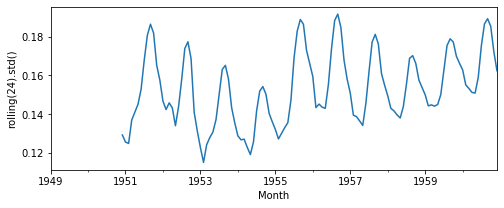

In [46]:
airlines_logged.rolling(24).std().plot(figsize=(8, 3))
plt.ylabel('rolling(24).std()')
plt.show()

The next step is to **remove the trend**, so that the means of the timeseries is aproximatelly constant over time. A trivial way to remove the trend is to use the difference beween consecutive observations.

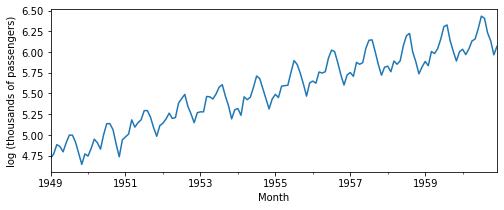

In [47]:
airlines_logged.plot(figsize=(8, 3))
plt.ylabel('log (thousands of passengers)')
plt.show()

In [48]:
airlines_logged_diff = airlines_logged.diff()

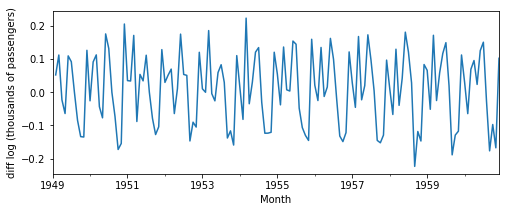

In [49]:
airlines_logged_diff.plot(figsize=(8, 3))
plt.ylabel('diff log (thousands of passengers)')
plt.show()

### 1.1 Auto regressive 

The first of our 3 parameters, `p`, is the "number of auto-regressive terms".  
What are auto-regressive terms? They are quite simply the lags of the dependent variable. Is the present point dependent on the previous one? On the previous two? Eight?  
Well, there's a rule of thumb to choose the lag before the first lag within the confidence interval. For example, lag 2 is already within the confidence interval (not completely, but let's consider so) so we'll go with lag 1, thus `p`=1. 

### 1.2 Integrated 

The "integrated" part of the name simply means that we take the diff between consecutive periods to make the time series stationary. We've already done this ahead of time (because we needed it for our ACF and PACF plots), but you can also leave it as a hyper parameter and tune it later. 


### 1.2 Moving Average 

The last of our 3 parameters, `q`, is the "number of moving average terms". 

The logic here is similar to the one we used for `p`, but instead of predicting values with lagged values, we are predicting errors with lagged errors. 

If not, just remember: 
> For `p` use the PACF  
> For `q` use the ACF. 

In [50]:
# from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(airlines_logged_diff.dropna().values, order=(1, 0, 0))
results = model.fit();

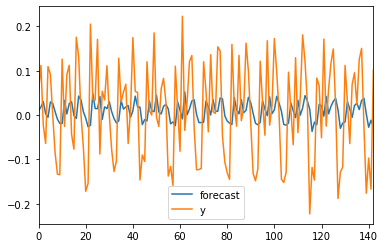

In [51]:
results.plot_predict()
plt.show()

A few differences between the statsmodels and sklearn:  

1. We pass the data straight to the model (sklearn example `reg = LinearRegression()`).
2. We used `.values` to get the numpy array instead of the pandas series.
3. We called `fit` without any parameters (sklearn example `reg.fit(X, y)`)
4. The model isn't fit in place, we have to grab the results with a results (sklearn example `y_hat = reg.predict(X)`)

## SARIMAX -  S (Seasonal) ARIMA X (with Exogenous variable)


SARIMAX Introduction [here](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html?highlight=predicted_mean).  
SARIMAX model class [documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html).  
SARIMAX results class [documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.html#statsmodels.tsa.statespace.mlemodel.MLEResults).  

What are the parameters? 

The ones below we already know. **Also note that now we're going to use d=1 to avoid having to difference the time series, and then transforming it back**. Also note that we still have to log the data, since SARIMAX can't do that by itself.
> p = 1  
> d = 1  
> q = 1  

But now we have a second bunch. The first 3 are analagous to the previous ones, but for the seasonal part. There are also guidelines on how to chose them, but for now we'll just use the following: 
> P = 1  
> D = 1  
> Q = 1  

The last new parameter, `S`, is an integer giving the periodicity (number of periods in season). 
We normally have a decent intuition for this parameter: 
- If we have daily data and suspect we may have weekly trends, we may want S = 7. 
- If the data is monthly and we think the time of the year may count, maybe try S = 12. 


### Running the model

In [52]:
# Initialize the model
model = SARIMAX(airlines_logged,             # <-- holy crap just passed it pandas? No ".values"? No .diff?
                order=(1, 1, 1),              # <-- keeping our order as before
                seasonal_order=(1, 0, 1, 12)) # <-- We'll get into how we found these hyper params

# Fit the model
results = model.fit(maxiter=100)

# Get predictions
pred = results.get_prediction()

# get prediction mean value as pandas.Series
predictions = pred.predicted_mean

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\envs\BLU05\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


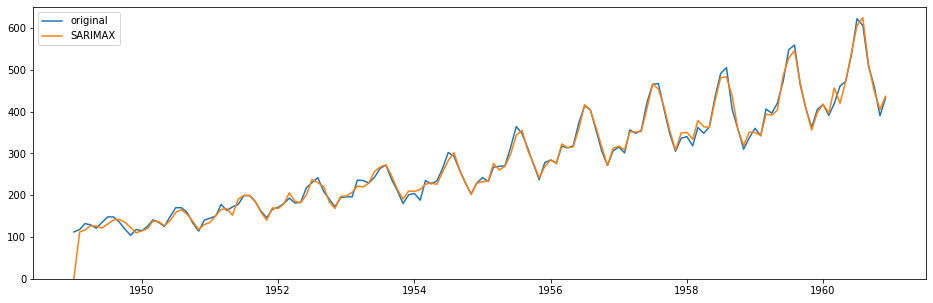

In [53]:
plt.figure(figsize=(16, 5))
plt.plot(airlines, label='original')
plt.plot(np.exp(predictions), label='SARIMAX')
plt.legend()
plt.ylim((0, 650))
plt.show();

### Validation

The standard metric for timeseries claisscal models is the **AIC (Akaike information criterion)**, which is a metric that will simutaneously measure how well the model fits the data, but will control for how complex the model is. If the model is very complex, the expectation on how well it must fit the data will also go up. It is therefore useful for comparing models.

In [54]:
results.aic

-498.8075617892029

Smaller is better, so the more negative the better.

There are also other metrics, such as R², but for that we'd need to create a validation set to avoid overfitting. Since AIC already penalizes complexity, we can use it without a validation set.